<a href="https://colab.research.google.com/github/ryuan19/focal_calibration_project/blob/main/evaluate_single_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf focal_calibration_project
!git clone https://github.com/ryuan19/focal_calibration_project

Cloning into 'focal_calibration_project'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 373 (delta 27), reused 53 (delta 27), pack-reused 320
Receiving objects: 100% (373/373), 85.01 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [10]:
!cd focal_calibration_project; ls; git pull

appspec.yml	  Experiments  Net		       train.py
Data		  LICENSE      README.md	       train_scripts
environment.yml   Losses       resnet50_results.png    train_utils.py
evaluate.py	  Metrics      roc.png
evaluate_scripts  models       temperature_scaling.py
Already up to date.


This notebook takes a trained model and evaluates it on the following metrics:
1. ECE pre and post temperature scaling
2. MCE pre and post temperature scaling
3. Test error

In [3]:
import os
import sys
cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import random
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

# sys.path.insert(1, '/focal_calibration_project')


In [4]:
# Import dataloaders
import focal_calibration_project.Data.cifar10  as cifar10
import focal_calibration_project.Data.cifar100 as cifar100
import focal_calibration_project.Data.tiny_imagenet as tiny_imagenet

In [5]:
# Import network architectures
from focal_calibration_project.Net.resnet import resnet50, resnet110
from focal_calibration_project.Net.wide_resnet import wide_resnet_cifar
from focal_calibration_project.Net.densenet import densenet121
from focal_calibration_project.Net.resnet_tiny_imagenet import resnet50 as resnet50_ti

In [6]:
# Import metrics to compute
from focal_calibration_project.Metrics.metrics import expected_calibration_error
from focal_calibration_project.Metrics.metrics import maximum_calibration_error
from focal_calibration_project.Metrics.metrics import l2_error
from focal_calibration_project.Metrics.plots import reliability_plot, bin_strength_plot
from focal_calibration_project.Metrics.metrics import test_classification_net

In [7]:
# Dataset params

dataset_num_classes = {
    'cifar10': 10,
    'cifar100': 100,
    'tiny_imagenet': 200
}

dataset_loader = {
    'cifar10': cifar10,
    'cifar100': cifar100,
    'tiny_imagenet': tiny_imagenet
}

In [8]:
# Mapping model name to model function
models = {
    'resnet50': resnet50,
    'resnet50_ti': resnet50_ti,
    'resnet110': resnet110,
    'wide_resnet': wide_resnet_cifar,
    'densenet121': densenet121,
}

In [9]:
# Checking if GPU is available
cuda = False
if (torch.cuda.is_available()):
    cuda = True

# Setting additional parameters
torch.manual_seed(1)
device = torch.device("cuda" if cuda else "cpu")

In [10]:
class args:
    data_aug = True
    gpu = device == "cuda"
    train_batch_size = 128
    test_batch_size = 128

In [11]:
# Taking input for the dataset
# print ('Enter the dataset: ')
# dataset = input()
dataset = 'cifar10'
num_classes = dataset_num_classes[dataset]

if (dataset == 'tiny_imagenet'):
    print ('Enter dataset root path: ')
    dataset_root = input()
    train_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='train',
        batch_size=args.train_batch_size,
        pin_memory=args.gpu)

    val_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)

    test_loader = dataset_loader[dataset].get_data_loader(
        root=dataset_root,
        split='val',
        batch_size=args.test_batch_size,
        pin_memory=args.gpu)
else:
    train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
        batch_size=args.train_batch_size,
        augment=args.data_aug,
        random_seed=1,
        pin_memory=args.gpu
    )

    test_loader = dataset_loader[dataset].get_test_loader(
        batch_size=args.test_batch_size,
        pin_memory=args.gpu
    )

Enter the dataset: 
cifar10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [12]:
# Taking input for the model
# print ('Enter the model: ')
# model_name = input()
# print ('Enter saved model name: ')
# saved_model_name = input()

model_name = "resnet50"
saved_model_name = "focal_calibration_project/models/resnet50_iq_loss_alpha_1.0_best_9.model"

model = models[model_name]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[599   6  56  29  22   0   7   4 262  15]
 [  4 804   1   2   1   1   5   0 111  71]
 [ 27   0 690  71  79  22  66  21  20   4]
 [  9   3  47 701  49  47  61  31  35  17]
 [  4   0  35  60 801   3  32  43  16   6]
 [  2   1  53 212  42 584  28  64  11   3]
 [  5   1  48  38  32   8 843  11  12   2]
 [  6   0  18  30  63  19   3 819  29  13]
 [  8   3   4   6   1   0   2   2 972   2]
 [ 10  15   3   5   1   0   1   3 117 845]]
Test error: 0.23419999999999996
ECE: 0.055448553127050396
MCE: 0.19011494517326355


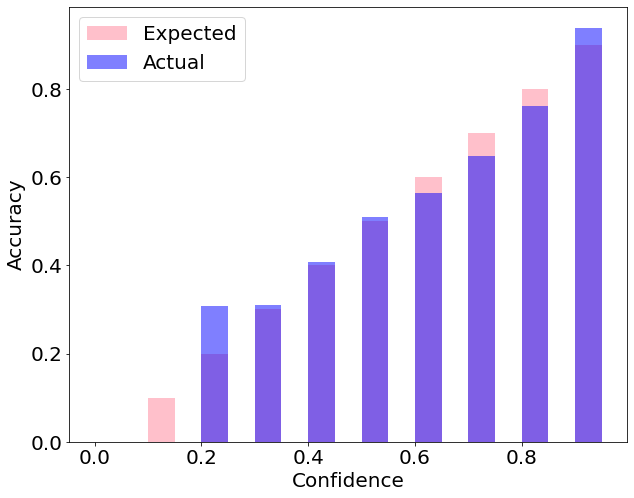

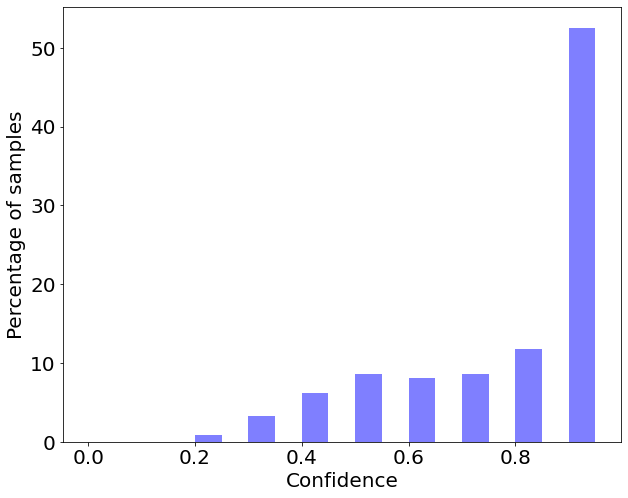

In [13]:
# Evaluating the model at T = 1
# Getting the number of bins
# print ('Enter the number of bins: ')
# num_bins = int(input())
num_bins = 10
net = model(num_classes=num_classes, temp=1.0)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load('./' + str(saved_model_name)))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

# Printing the required evaluation metrics
print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins)
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins)

Enter the number of bins: 
15
Enter the optimal temperature: 
2.5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[599   6  56  29  22   0   7   4 262  15]
 [  4 804   1   2   1   1   5   0 111  71]
 [ 27   0 690  71  79  22  66  21  20   4]
 [  9   3  47 701  49  47  61  31  35  17]
 [  4   0  35  60 801   3  32  43  16   6]
 [  2   1  53 212  42 584  28  64  11   3]
 [  5   1  48  38  32   8 843  11  12   2]
 [  6   0  18  30  63  19   3 819  29  13]
 [  8   3   4   6   1   0   2   2 972   2]
 [ 10  15   3   5   1   0   1   3 117 845]]
Test error: 0.23419999999999996
ECE: 0.2046683874890208
MCE: 0.28991414777934543


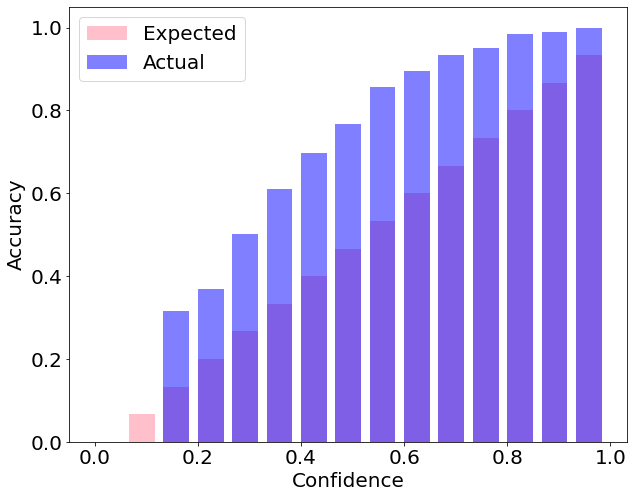

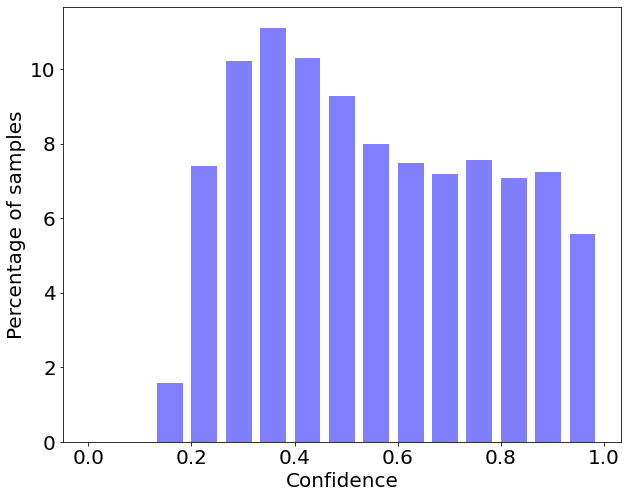

In [15]:
# Evaluating the model at T = T_opt
# Getting the number of bins
print ('Enter the number of bins: ')
num_bins = int(input())
print ('Enter the optimal temperature: ')
t_opt = float(input())

net = model(num_classes=num_classes, temp=t_opt)
net.cuda()
net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
net.load_state_dict(torch.load('./' + str(saved_model_name)))

conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(net, test_loader, device)
ece = expected_calibration_error(confidences, predictions, labels, num_bins=num_bins)
mce = maximum_calibration_error(confidences, predictions, labels, num_bins=num_bins)

print (conf_matrix)
print ('Test error: ' + str((1 - accuracy)))
print ('ECE: ' + str(ece))
print ('MCE: ' + str(mce))

# Plotting the reliability plot
reliability_plot(confidences, predictions, labels, num_bins=num_bins)
bin_strength_plot(confidences, predictions, labels, num_bins=num_bins)

appspec.yml	  Experiments  Net		       train.py
Data		  LICENSE      README.md	       train_scripts
environment.yml   Losses       resnet50_results.png    train_utils.py
evaluate.py	  Metrics      roc.png
evaluate_scripts  models       temperature_scaling.py
fatal: could not read Username for 'https://github.com': No such device or address
